# data

> data handling routines

In [ ]:
#| default_exp data

In [ ]:
#| hide
from nbdev.showdoc import *


In [ ]:
#| export
import os 
from torch.utils.data import Dataset
from glob import glob 
import random
from PIL import Image
import numpy as np
import torch

In [ ]:
#| export
class PRPairDataset(Dataset):
    "piano roll pair dataset"
    def __init__(self, 
            image_dataset_dir='~/datasets/POP909_images/', 
            crop_size=128, 
            max_shift_x=10, 
            max_shift_y=12,
            split='train',
            val_fraction=0.1,
            seed=42,
            verbose=True):
        self.crop_size, self.max_shift_x, self.max_shift_y = crop_size, max_shift_x, max_shift_y
        
        # Load and split filenames
        all_filenames = glob(os.path.join(os.path.expanduser(image_dataset_dir), '**/*.png'), recursive=True)
        rng = random.Random(seed)
        shuffled = all_filenames.copy()
        rng.shuffle(shuffled)
        split_idx = int(len(shuffled) * (1 - val_fraction))
        
        if split == 'train':
            self.filenames = shuffled[:split_idx]
        else:
            self.filenames = shuffled[split_idx:]
            
        self.actual_len = len(self.filenames)
        self.images = []
        if verbose: print(f"Loading {self.actual_len} {split} files from {image_dataset_dir}...")
        for f in self.filenames: 
            img = Image.open(f).convert('L')  # grayscale
            #img = torch.from_numpy(np.array(img)).float() / 255.0 # moved to getitem to save RAM on solveit
            self.images.append(np.array(img, dtype=np.uint8))
        if verbose: print(f"Finished loading.")

    def __len__(self):
        return self.actual_len * 100  # arbitrary large number for epoch length

    def __getitem__(self, idx):
        # ignore idx, just randomly sample
        file_idx = random.randint(0, self.actual_len - 1)
        img = self.images[file_idx]
        img = torch.from_numpy(img).float() / 255.0
        img = (img > 0.25).float()  # binarize
        h, w = img.shape
        
        # sample shift_x (non-zero)
        shift_x = random.choice([i for i in range(-self.max_shift_x, self.max_shift_x + 1) if i != 0])
        
        # sample loc1 such that both crops are valid
        min_loc = max(0, -shift_x)
        max_loc = min(w - self.crop_size, w - self.crop_size - shift_x)
        loc1 = random.randint(min_loc, max_loc)
        loc2 = loc1 + shift_x
        
        # crop horizontally
        img1 = img[:, loc1:loc1 + self.crop_size]
        img2 = img[:, loc2:loc2 + self.crop_size]
        
        # y-shifts (transposition)
        shift_y = random.randint(-self.max_shift_y, self.max_shift_y)
        img2 = torch.roll(img2, shifts=shift_y, dims=0) # 'roll' is ok because "there's never any notes near top or bottom" 🤞
        

        return {
            'img1': img1.unsqueeze(0),  # add channel dim (1, 128, 128)
            'img2': img2.unsqueeze(0),
            'deltas': torch.tensor([shift_x, shift_y], dtype=torch.float32).abs(),
            'file_idx': file_idx,
        }


Code to test that: 

In [ ]:
#| eval: false
data = PRPairDataset()
print("len(data) =",len(data))
print("data.actual_len =",data.actual_len)
data_dict = next(iter(data)) 
print("data_dict =n",data_dict)

# Let's take the sum to make sure there's some non-zero pixel values
for imstr in ['img1','img2']:
    print(f"data_dict['{imstr}'].sum() = ",data_dict[imstr].sum())

Loading 818 train files from ~/datasets/POP909_images/...


Finished loading.
len(data) = 81800
data.actual_len = 818
data_dict =n {'img1': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 'img2': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]]), 'deltas': tensor([3., 9.]), 'file_idx': 201}
data_dict['img1'].sum() =  tensor(337.7961)
data_dict['img2'].sum() =  tensor(340.7451)


top row: img1, bottom row: img2


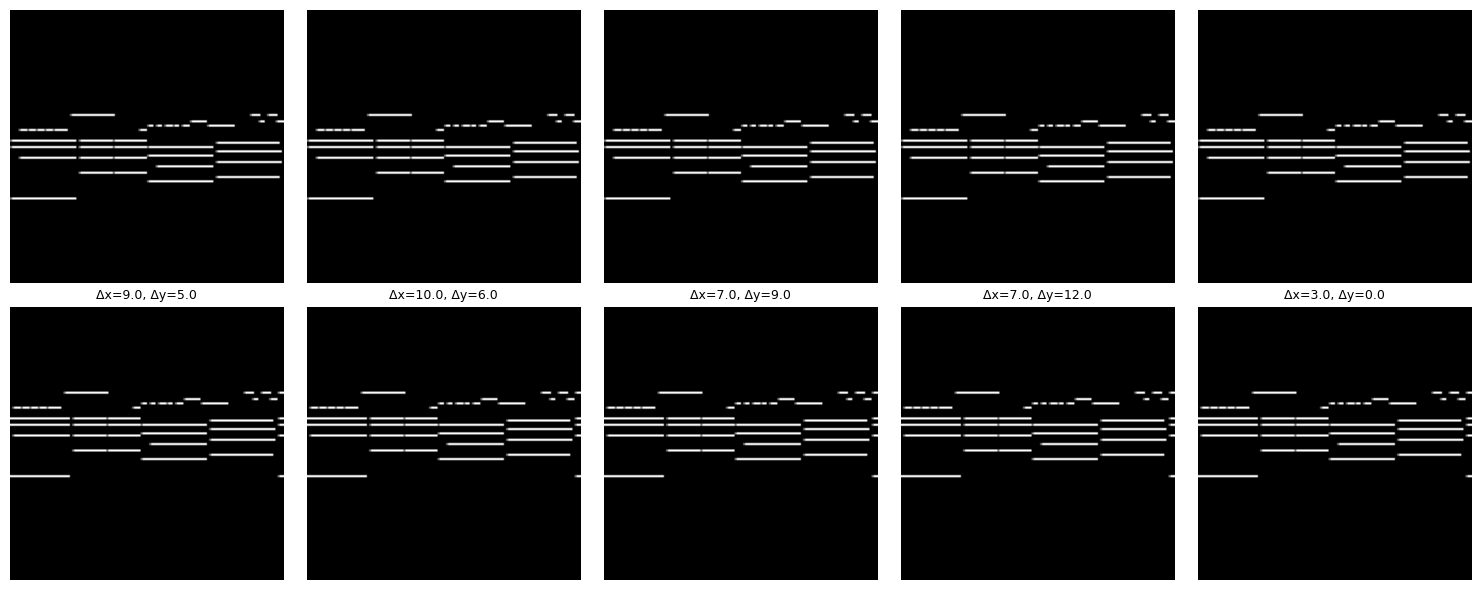

In [ ]:
#| eval: false
import matplotlib.pyplot as plt

samples = [data[i] for i in range(5)]
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
print("top row: img1, bottom row: img2")
for i in range(5):
    sample = samples[i]
    for j, imstr in enumerate(['img1','img2']): 
        axes[j, i].imshow(data_dict[imstr].squeeze(), cmap='gray') # top row: img1, bottom row: img2
        axes[j, i].axis('off')
    axes[1, i].set_title(f"Δx={sample['deltas'][0]}, Δy={sample['deltas'][1]}", fontsize=9)

plt.tight_layout()
plt.show()


In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()